<a href="https://colab.research.google.com/github/Aarush-Aggarwal/Kaggle/blob/main/Financial_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imported Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from   sklearn.manifold import TSNE
from   sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv('drive/MyDrive/Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [2]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [3]:
# Checking for the Null Values
df.isnull().sum().max()

0

In [4]:
# Checking for skewed classes
print('No Frauds', round(df['isFraud'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['isFraud'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.87 % of the dataset
Frauds 0.13 % of the dataset


# Plotting : Class Distribution

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

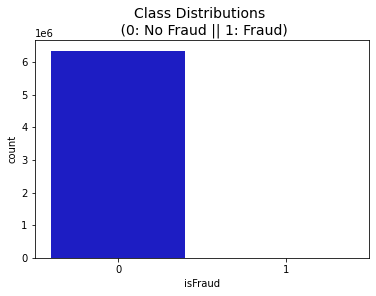

In [5]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('isFraud', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

# Plotting : Distribution of the Data

(0.0, 356179278.92)

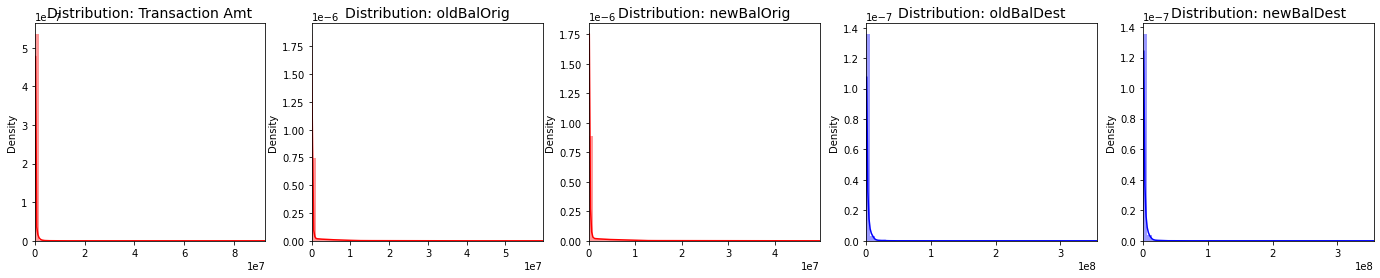

In [6]:
fig, ax = plt.subplots(1, 5, figsize=(24,4))

amount_val         = df['amount'].values
oldBalanceOrig_val = df['oldbalanceOrg'].values
newBalanceOrig_val = df['newbalanceOrig'].values
oldBalanceDest_val = df['oldbalanceDest'].values
newBalanceDest_val = df['newbalanceDest'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution: Transaction Amt', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(oldBalanceOrig_val, ax=ax[1], color='r')
ax[1].set_title('Distribution: oldBalOrig', fontsize=14)
ax[1].set_xlim([min(oldBalanceOrig_val), max(oldBalanceOrig_val)])

sns.distplot(newBalanceOrig_val, ax=ax[2], color='r')
ax[2].set_title('Distribution: newBalOrig', fontsize=14)
ax[2].set_xlim([min(newBalanceOrig_val), max(newBalanceOrig_val)])

sns.distplot(oldBalanceDest_val, ax=ax[3], color='b')
ax[3].set_title('Distribution: oldBalDest', fontsize=14)
ax[3].set_xlim([min(oldBalanceDest_val), max(oldBalanceDest_val)])

sns.distplot(newBalanceDest_val, ax=ax[4], color='b')
ax[4].set_title('Distribution: newBalDest', fontsize=14)
ax[4].set_xlim([min(newBalanceDest_val), max(newBalanceDest_val)])

In [7]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# Scaling the Data

In [8]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['amount'].values.reshape(-1,1))
df['scaled_oldBalOrig'] = rob_scaler.fit_transform(df['oldbalanceOrg'].values.reshape(-1,1))
df['scaled_newBalOrig'] = rob_scaler.fit_transform(df['newbalanceOrig'].values.reshape(-1,1))
df['scaled_oldBalDest'] = rob_scaler.fit_transform(df['oldbalanceDest'].values.reshape(-1,1))
df['scaled_newBalDest'] = rob_scaler.fit_transform(df['newbalanceDest'].values.reshape(-1,1))

df.drop('amount', axis=1, inplace=True)
scaled_amount = df['scaled_amount']
df.drop('scaled_amount', axis=1, inplace=True)
df.insert(3, 'scaled_amount', scaled_amount)

df.drop('oldbalanceOrg', axis=1, inplace=True)
scaled_oldBalOrig = df['scaled_oldBalOrig']
df.drop('scaled_oldBalOrig', axis=1, inplace=True)
df.insert(4, 'scaled_oldBalOrig', scaled_oldBalOrig)

df.drop('newbalanceOrig', axis=1, inplace=True)
scaled_newBalOrig = df['scaled_newBalOrig']
df.drop('scaled_newBalOrig', axis=1, inplace=True)
df.insert(5, 'scaled_newBalOrig', scaled_newBalOrig)

df.drop('oldbalanceDest', axis=1, inplace=True)
scaled_oldBalDest = df['scaled_oldBalDest']
df.drop('scaled_oldBalDest', axis=1, inplace=True)
df.insert(6, 'scaled_oldBalDest', scaled_oldBalDest)

df.drop('newbalanceDest', axis=1, inplace=True)
scaled_newBalDest = df['scaled_newBalDest']
df.drop('scaled_newBalDest', axis=1, inplace=True)
df.insert(7, 'scaled_newBalDest', scaled_newBalDest)

# Splitting the Data

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['isFraud'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['isFraud'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('isFraud', axis=1)
y = df['isFraud']

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in skf.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why original_ is used to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest  = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest  = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.87 % of the dataset
Frauds 0.13 % of the dataset
Train: [1272422 1272423 1272424 ... 6362617 6362618 6362619] Test: [      0       1       2 ... 1510291 1510292 1510293]
Train: [      0       1       2 ... 6362617 6362618 6362619] Test: [1272422 1272423 1272424 ... 3958614 3958615 3958622]
Train: [      0       1       2 ... 6362617 6362618 6362619] Test: [2544062 2544063 2544064 ... 6009078 6009346 6009347]
Train: [      0       1       2 ... 6362617 6362618 6362619] Test: [3815834 3815835 3815836 ... 6243165 6243166 6243645]
Train: [      0       1       2 ... 6243165 6243166 6243645] Test: [5087485 5087486 5087487 ... 6362617 6362618 6362619]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99870926 0.00129074]
[0.99870887 0.00129113]


In [10]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

# does not create new memory object though reference object changes i.e. id(df) changes but not the underlying C object
# df = df.sample(frac=1).reset_index(drop=True) # drop=True prevents .reset_index() from creating a column containing the old index entries
df = df.sample(frac=1) # if passed, argument random_state=42 makes sure that random choice is always replicatable

# only number equal to fraud classes is taken for both fraud df as well as non-fraud df
fraud_df = df.loc[df['isFraud'] == 1]
non_fraud_df = df.loc[df['isFraud'] == 0][:df.isFraud.value_counts()[1]]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,step,type,nameOrig,scaled_amount,scaled_oldBalOrig,scaled_newBalOrig,scaled_oldBalDest,scaled_newBalDest,nameDest,isFraud,isFlaggedFraud
4018451,299,PAYMENT,C7647586,-0.333576,0.309537,0.261421,-0.140722,-0.193057,M2082449294,0,0
4916304,350,CASH_IN,C17117594,0.582763,0.060989,1.451957,0.515802,0.194045,C1056775291,0,0
6201836,579,CASH_OUT,C1904414737,7.503908,14.223680,0.000000,-0.057997,1.262671,C2037994906,1,0
2036947,180,CASH_OUT,C686087807,27.075571,49.847441,0.000000,0.001873,4.751652,C1701906322,1,0
167557,12,CASH_OUT,C684252268,10.195957,19.123667,0.000000,0.065538,2.593652,C2027569559,1,0


Distribution of the Classes in the subsample dataset
0    0.5
1    0.5
Name: isFraud, dtype: float64


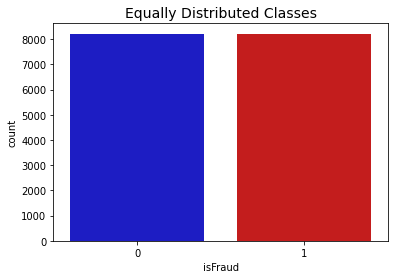

In [11]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['isFraud'].value_counts()/len(new_df))

sns.countplot('isFraud', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

# Correlation Matrices

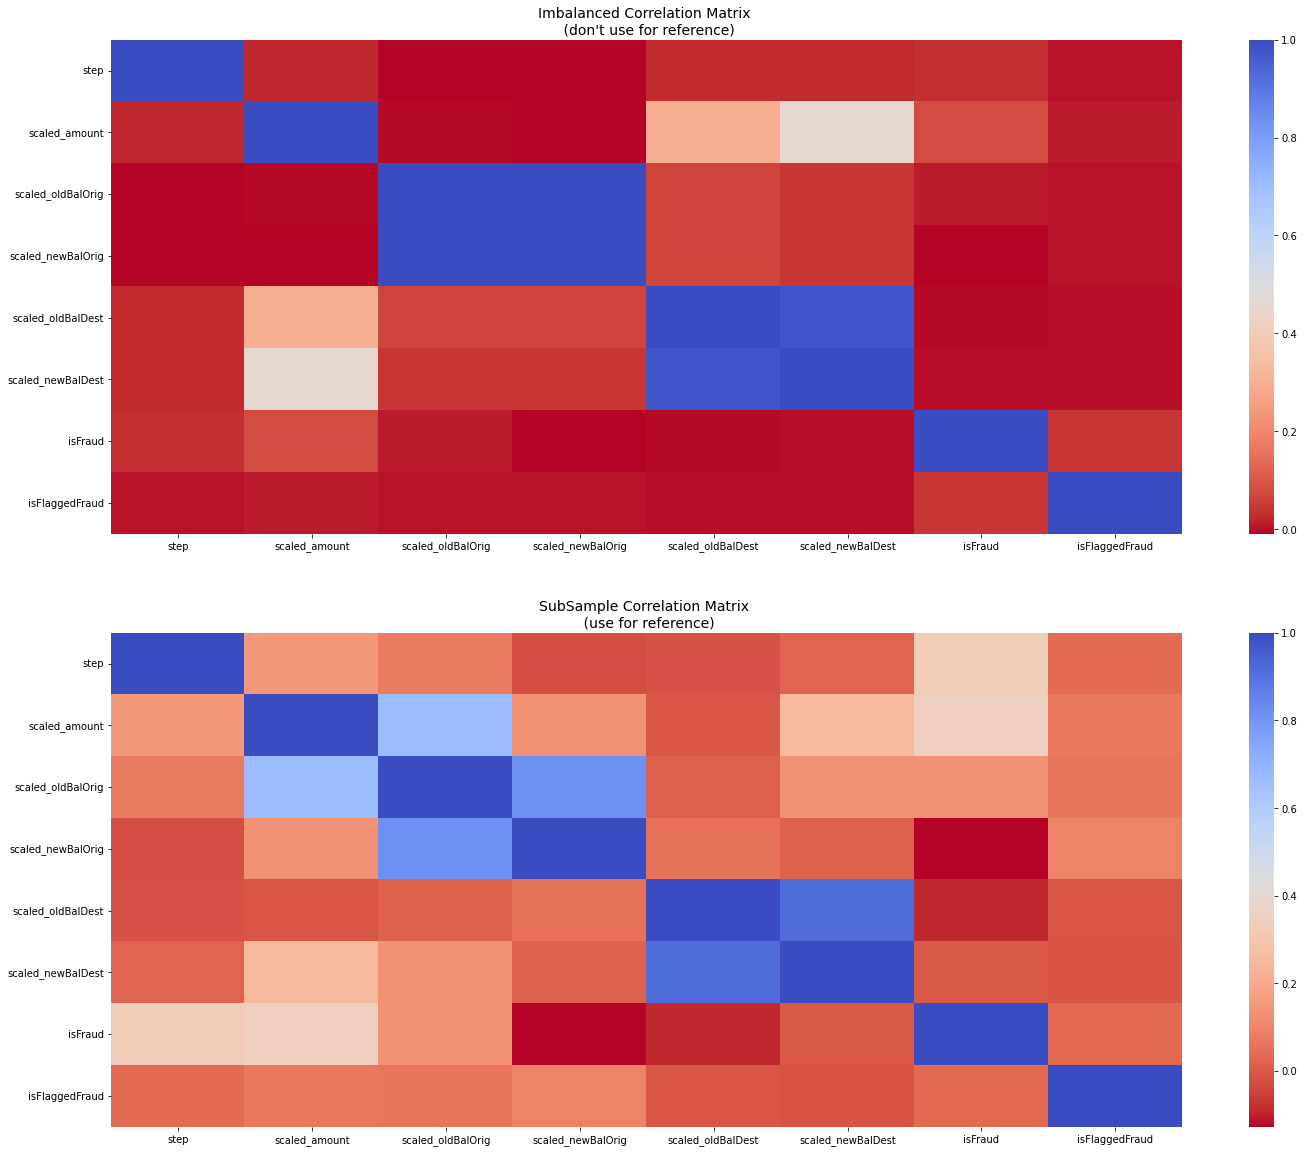

In [12]:
# Make sure we use the subsample in our correlation
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# df.corr() calculates the correlation matrix whose elements range is [-1, 1], by default it uses Pearson Correlation coefficient. 
# sns.heatmap displays using colors how strong the correlations are

# It's just a way to see the correlations with colors instead of a number so the user can identify which variables are more correlated.

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

# Subsampled DataFrame
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

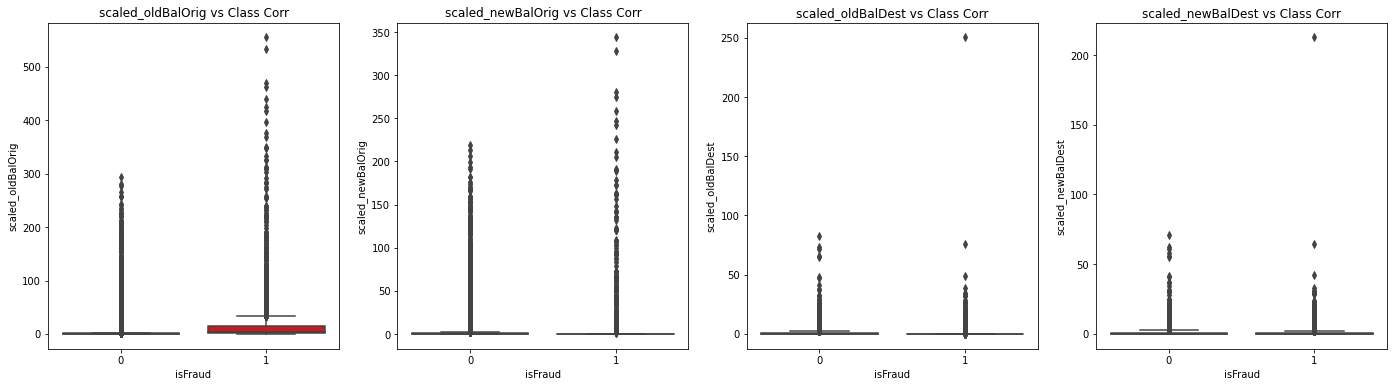

In [14]:
f, axes = plt.subplots(ncols=4, figsize=(24,6))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="isFraud", y="scaled_oldBalOrig", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('scaled_oldBalOrig vs Class Corr')

sns.boxplot(x="isFraud", y="scaled_newBalOrig", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('scaled_newBalOrig vs Class Corr')


sns.boxplot(x="isFraud", y="scaled_oldBalDest", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('scaled_oldBalDest vs Class Corr')


sns.boxplot(x="isFraud", y="scaled_newBalDest", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('scaled_newBalDest vs Class Corr')

plt.show()


# Anomaly Detection:

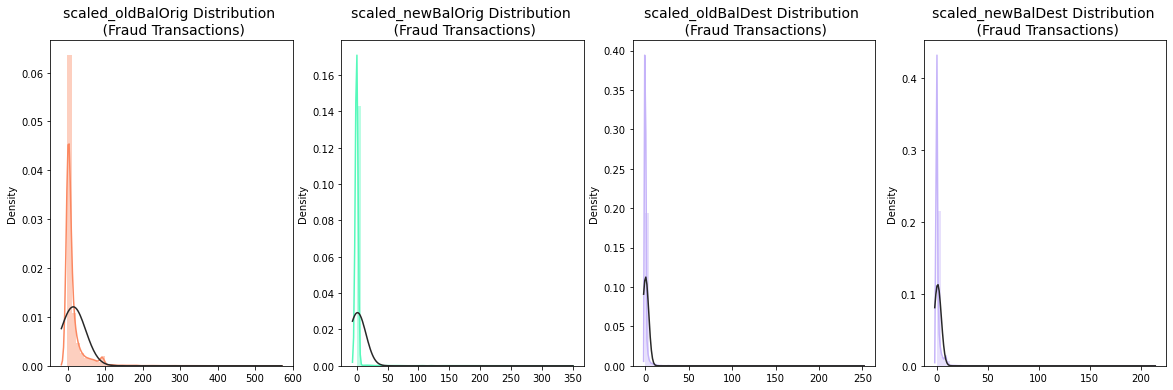

In [15]:
from scipy.stats import norm

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20, 6))

oldBalOrig_fraud_dist = new_df['scaled_oldBalOrig'].loc[new_df['isFraud'] == 1].values
sns.distplot(oldBalOrig_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('scaled_oldBalOrig Distribution \n (Fraud Transactions)', fontsize=14)

newBalOrig_fraud_dist = new_df['scaled_newBalOrig'].loc[new_df['isFraud'] == 1].values
sns.distplot(newBalOrig_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('scaled_newBalOrig Distribution \n (Fraud Transactions)', fontsize=14)


oldBalDest_fraud_dist = new_df['scaled_oldBalDest'].loc[new_df['isFraud'] == 1].values
sns.distplot(oldBalDest_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('scaled_oldBalDest Distribution \n (Fraud Transactions)', fontsize=14)

newBalDest_fraud_dist = new_df['scaled_newBalDest'].loc[new_df['isFraud'] == 1].values
sns.distplot(newBalDest_fraud_dist,ax=ax4, fit=norm, color='#C5B3F9')
ax4.set_title('scaled_newBalDest Distribution \n (Fraud Transactions)', fontsize=14)


plt.show()

In [16]:
# # -----> oldBalanceOrig Removing Outliers
oldBalOrig_fraud = new_df['scaled_oldBalOrig'].loc[new_df['isFraud'] == 1].values
q25, q75 = np.percentile(oldBalOrig_fraud, 25), np.percentile(oldBalOrig_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
oldBalOrig_iqr = q75 - q25
print('iqr: {}'.format(oldBalOrig_iqr))

oldBalOrig_cut_off = oldBalOrig_iqr * 1.5
oldBalOrig_lower, oldBalOrig_upper = q25 - oldBalOrig_cut_off, q75 + oldBalOrig_cut_off
print('Cut Off: {}'.format(oldBalOrig_cut_off))
print('oldBalOrig Lower: {}'.format(oldBalOrig_lower))
print('oldBalOrig Upper: {}'.format(oldBalOrig_upper))

outliers = [x for x in oldBalOrig_fraud if x < oldBalOrig_lower or x > oldBalOrig_upper]
print('Feature oldBalOrig Outliers for Fraud Cases: {}'.format(len(outliers)))
print('oldBalOrig outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['scaled_oldBalOrig'] > oldBalOrig_upper) | (new_df['scaled_oldBalOrig'] < oldBalOrig_lower)].index)
print('----' * 40)

# -----> scaled_newBalOrig removing outliers from fraud transactions
newBalOrig_fraud = new_df['scaled_newBalOrig'].loc[new_df['isFraud'] == 1].values
q25, q75 = np.percentile(newBalOrig_fraud, 25), np.percentile(newBalOrig_fraud, 75)
newBalOrig_iqr = q75 - q25

newBalOrig_cut_off = newBalOrig_iqr * 1.5
newBalOrig_lower, newBalOrig_upper = q25 - newBalOrig_cut_off, q75 + newBalOrig_cut_off
print('newBalOrig Lower: {}'.format(newBalOrig_lower))
print('newBalOrig Upper: {}'.format(newBalOrig_upper))
outliers = [x for x in newBalOrig_fraud if x < newBalOrig_lower or x > newBalOrig_upper]
print('newBalOrig outliers: {}'.format(outliers))
print('Feature newBalOrig Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['scaled_newBalOrig'] > newBalOrig_upper) | (new_df['scaled_newBalOrig'] < newBalOrig_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 40)


# Removing outliers scaled_oldBalDest Feature
oldBalDest_fraud = new_df['scaled_oldBalDest'].loc[new_df['isFraud'] == 1].values
q25, q75 = np.percentile(oldBalDest_fraud, 25), np.percentile(oldBalDest_fraud, 75)
oldBalDest_iqr = q75 - q25

oldBalDest_cut_off = oldBalDest_iqr * 1.5
oldBalDest_lower, oldBalDest_upper = q25 - oldBalDest_cut_off, q75 + oldBalDest_cut_off
print('oldBalDest Lower: {}'.format(oldBalDest_lower))
print('oldBalDest Upper: {}'.format(oldBalDest_upper))
outliers = [x for x in oldBalDest_fraud if x < oldBalDest_lower or x > oldBalDest_upper]
print('oldBalDest outliers: {}'.format(outliers))
print('Feature oldBalDest Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['scaled_oldBalDest'] > oldBalDest_upper) | (new_df['scaled_oldBalDest'] < oldBalDest_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 40)

# Removing outliers scaled_newBalDest Feature
newBalDest_fraud = new_df['scaled_newBalDest'].loc[new_df['isFraud'] == 1].values
q25, q75 = np.percentile(newBalDest_fraud, 25), np.percentile(newBalDest_fraud, 75)
newBalDest_iqr = q75 - q25

newBalDest_cut_off = newBalDest_iqr * 1.5
newBalDest_lower, newBalDest_upper = q25 - newBalDest_cut_off, q75 + newBalDest_cut_off
print('newBalDest Lower: {}'.format(newBalDest_lower))
print('newBalDest Upper: {}'.format(newBalDest_upper))
outliers = [x for x in newBalDest_fraud if x < newBalDest_lower or x > newBalDest_upper]
print('newBalDest outliers: {}'.format(outliers))
print('Feature newBalDest Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['scaled_newBalDest'] > newBalDest_upper) | (new_df['scaled_newBalDest'] < newBalDest_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: 1.0400620415519053 | Quartile 75: 14.010725696528938
iqr: 12.970663654977033
Cut Off: 19.45599548246555
oldBalOrig Lower: -18.415933440913644
oldBalOrig Upper: 33.46672117899449
Feature oldBalOrig Outliers for Fraud Cases: 999
oldBalOrig outliers:[49.84744105388637, 36.893863705668835, 47.40846716226293, 51.736951647332255, 60.85940930534754, 112.3243375412657, 83.09542327075366, 99.13736384439574, 62.25459530769996, 93.05107129536898, 57.63211959538807, 93.05107129536898, 34.08321199681219, 40.872596443140495, 61.14414965078331, 43.81579287365464, 45.455064952370435, 93.05107129536898, 50.4583436592262, 69.09215271745119, 70.46642387714506, 93.05107129536898, 34.70494177547583, 34.41390632778635, 96.34859394302809, 37.346914730372475, 60.29267342666123, 93.05107129536898, 40.33329275193373, 70.34726365586228, 41.84687356657621, 139.21316421466022, 38.277704807358326, 93.05107129536898, 182.44978522375794, 46.61667215284325, 114.68485766341992, 93.05107129536898, 43.793691

In [17]:
f,(ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature scaled_oldBalOrig
sns.boxplot(x="isFraud", y="scaled_oldBalOrig", data=new_df,ax=ax1, palette=colors)
ax1.set_title("scaled_oldBalOrig Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12), arrowprops=dict(facecolor='black'), fontsize=14)

# Feature scaled_newBalOrig
sns.boxplot(x="isFraud", y="scaled_newBalOrig", data=new_df, ax=ax2, palette=colors)
ax2.set_title("scaled_newBalOrig Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12), arrowprops=dict(facecolor='black'), fontsize=14)

# Feature scaled_oldBalDest
sns.boxplot(x="isFraud", y="scaled_oldBalDest", data=new_df, ax=ax3, palette=colors)
ax3.set_title("scaled_oldBalDest Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12), arrowprops=dict(facecolor='black'),fontsize=14)

# Feature scaled_newBalDest
sns.boxplot(x="isFraud", y="scaled_newBalDest", data=new_df, ax=ax4, palette=colors)
ax4.set_title("scaled_newBalDest Feature \n Reduction of outliers", fontsize=14)
ax4.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12), arrowprops=dict(facecolor='black'),fontsize=14)

plt.show()

# Dimensionality Reduction and Clustering

In [20]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('isFraud', axis=1)
y = new_df['isFraud']

# # T-SNE Implementation
# t0 = time.time()
# X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
# t1 = time.time()
# print("T-SNE took {:.2} s".format(t1 - t0))

# # PCA Implementation
# t0 = time.time()
# X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
# t1 = time.time()
# print("PCA took {:.2} s".format(t1 - t0))

# # TruncatedSVD
# t0 = time.time()
# X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
# t1 = time.time()

,step,type,nameOrig,scaled_amount,scaled_oldBalOrig,scaled_newBalOrig,scaled_oldBalDest,scaled_newBalDest,nameDest,isFlaggedFraud
6281809,652,TRANSFER,C534774470,10.135362,19.013374,0.0,-0.140722,-0.193057,C304432488,0
6036302,476,CASH_OUT,C534886270,-0.191867,0.216057,0.0,0.157960,0.093893,C998024073,0
1510581,145,CASH_OUT,C1782679306,-0.334837,-0.044173,0.0,-0.042557,-0.101286,C1503937071,0


In [ ]:
f, (ax1, ax2, ax3,) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

# Classifiers

In [ ]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('isFraud', axis=1)
y = new_df['isFraud']

In [ ]:
# As data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [ ]:
# Let's implement simple classifiers
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [ ]:
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

In [ ]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV

# Logistic Regression 
LogReg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_LogReg = GridSearchCV(LogisticRegression(), LogReg_params)
grid_LogReg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
LogReg = grid_LogReg.best_estimator_


kNN_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_kNN = GridSearchCV(KNeighborsClassifier(), kNN_params)
grid_kNN.fit(X_train, y_train)

# kNN best estimator
kNN_neighbors = grid_kNN.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

In [ ]:
# Overfitting Case

LogReg_score = cross_val_score(LogReg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(LogReg_score.mean() * 100, 2).astype(str) + '%')


kNN_score = cross_val_score(kNN_neighbors, X_train, y_train, cv=5)
print('kNN Cross Validation Score', round(kNN_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

In [ ]:
# undersample during cross validating
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in skf.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way

for train, test in skf.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), LogReg) # SMOTE happens during Cross Validation
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

# Plotting : Learning Curves

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124", label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff", label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124", label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff", label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124", label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff", label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124", label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff", label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

In [ ]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(LogReg, kNN_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

LogReg_pred = cross_val_predict(LogReg, X_train, y_train, cv=5, method="decision_function")

kNN_pred = cross_val_predict(kNN_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5, method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [ ]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, LogReg_pred))
print('KNN Neighbors: ', roc_auc_score(y_train, kNN_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

In [ ]:
log_fpr, log_tpr, log_thresold        = roc_curve(y_train, LogReg_pred)
kNN_fpr, kNN_tpr, kNN_threshold = roc_curve(y_train, kNN_pred)
svc_fpr, svc_tpr, svc_threshold       = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold    = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, kNN_fpr, kNN_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, LogReg_pred)))
    plt.plot(kNN_fpr, kNN_tpr, label='KNN Classifier Score: {:.4f}'.format(roc_auc_score(y_train, kNN_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3), arrowprops=dict(facecolor='#6E726D', shrink=0.05),)
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, kNN_fpr, kNN_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

# Logistic Regression Classifier

In [ ]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
    
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, LogReg_pred)

In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = LogReg.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 45)

In [ ]:
undersample_y_score = LogReg.decision_function(original_Xtest)

In [ ]:
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(undersample_average_precision))

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(undersample_average_precision), fontsize=16)

# SMOTE Technique (Over-Sampling)

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# LogReg_sm = grid_LogReg.best_estimator_
LogReg_sm = LogisticRegression()

rand_LogReg = RandomizedSearchCV(LogisticRegression(), LogReg_params, n_iter=4)


# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
LogReg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in skf.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_LogReg) # SMOTE happens during Cross Validation
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_LogReg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')

In [ ]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

In [ ]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

In [ ]:
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

In [ ]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

In [ ]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(ratio='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)

In [ ]:
# We Improve the score by 2% points approximately 
# Implement GridSearchCV and the other models.

# Logistic Regression
t0 = time.time()
LogReg_sm = grid_LogReg.best_estimator_
LogReg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

# Test Data with Logistic Regression

In [ ]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_LogReg = LogReg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_kNN  = kNN_neighbors.predict(X_test)
y_pred_svc  = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


LogReg_cf = confusion_matrix(y_test, y_pred_LogReg)
kNN_cf    = confusion_matrix(y_test, y_pred_kNN)
svc_cf    = confusion_matrix(y_test, y_pred_svc)
tree_cf   = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(LogReg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kNN_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

In [ ]:
# Final Score in the test set of logistic regression
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = LogReg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)



# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)


d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)
# Note how high is accuracy score it can be misleading! 
final_df